# 프로젝트 루브릭
* 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
* 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
* 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

# 데이터 전처리

In [58]:
# 드라이브 마운트 / 구글 드라이브 전용
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [60]:
# 필요 패키지 불러오기
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
# 데이터 불러오기 [경로 지정]
data_dir = '/content/drive/MyDrive/대학/활동/아이펠/lms/기초다지기_rs8/나의 첫 번째 캐글 경진대회, 무작정 따라해보기'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/content/drive/MyDrive/대학/활동/아이펠/lms/기초다지기_rs8/나의 첫 번째 캐글 경진대회, 무작정 따라해보기/train.csv
/content/drive/MyDrive/대학/활동/아이펠/lms/기초다지기_rs8/나의 첫 번째 캐글 경진대회, 무작정 따라해보기/test.csv


In [62]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)

# 전처리 과정
1. 데이터 형태 확인
2. 데이터 결측치 확인
3. 데이터 빈데이터 채우기, 대체

In [63]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [65]:
# 전처리1.[date] - 전반적으로 숫자 분포가 괜찮지만  date값의 뒤 내용들이 크게 중요하지 않아 보임
train['date'] = train['date'].astype(str).apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].astype(str).apply(lambda i: i[:6]).astype(int)

In [66]:
# 전처리2. 훈련을 위해 price 데이터 분리
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [67]:
# 전처리3. 훈련에는 필요가 없는 데이터인 id값 제거
del train['id']
del test['id']

In [68]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


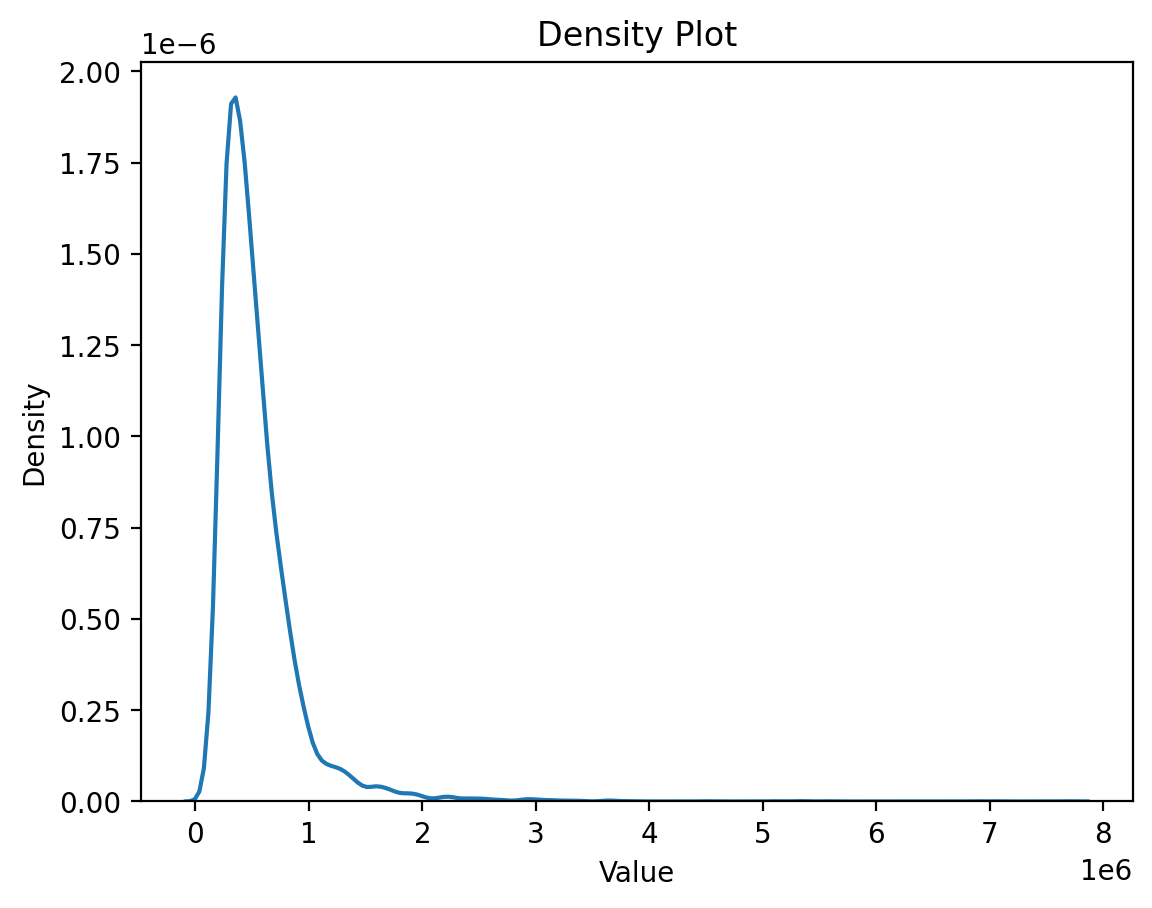

In [69]:
# 전처리 4 테스트 데이터 분포도 확인 및 처리
sns.kdeplot(y)

plt.title("Density Plot")
plt.xlabel("Value")
plt.ylabel("Density")

plt.show()

In [70]:
# y분포가 왼쪽으로 치우쳐져 있다는 문제가 있어서 로그 변환을 시행해주고 다시 제출할때 원상복구 작업 시행
y = np.log1p(y)
# 이후에 np.expm1()로 원상복귀
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

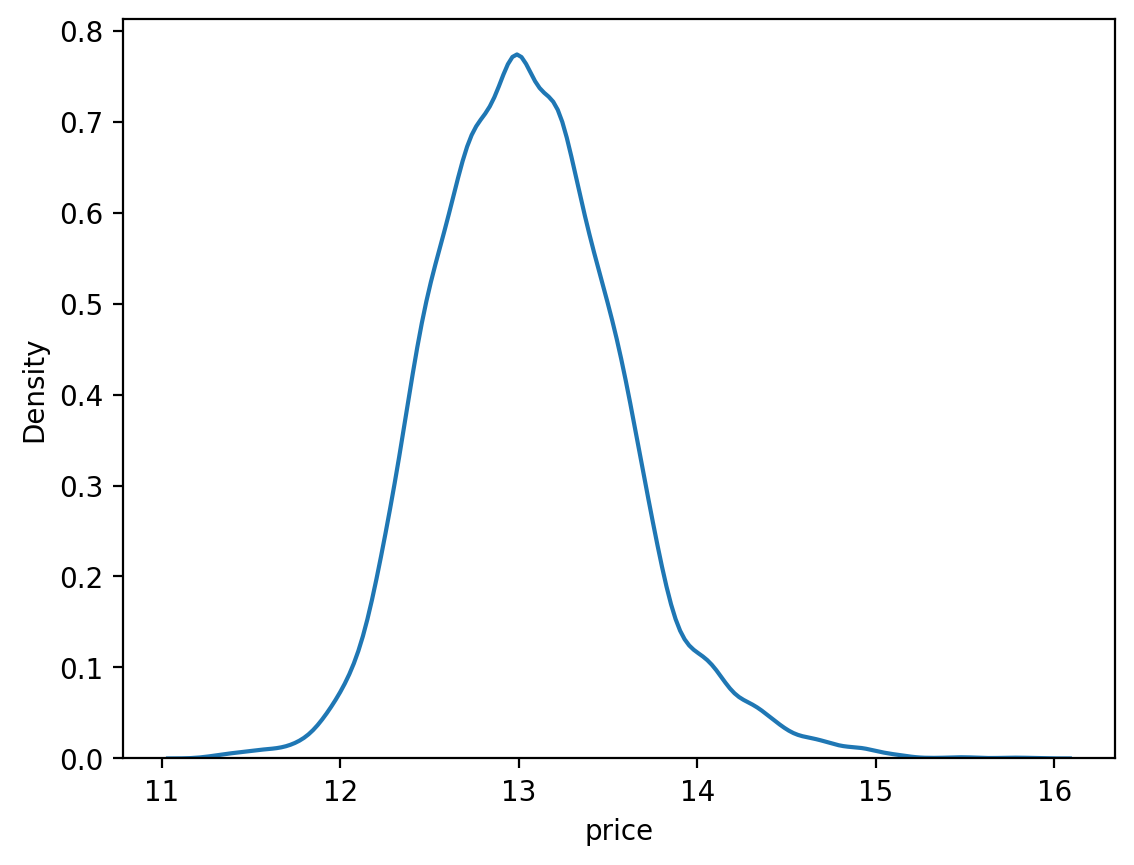

In [71]:
sns.kdeplot(y)
plt.show()

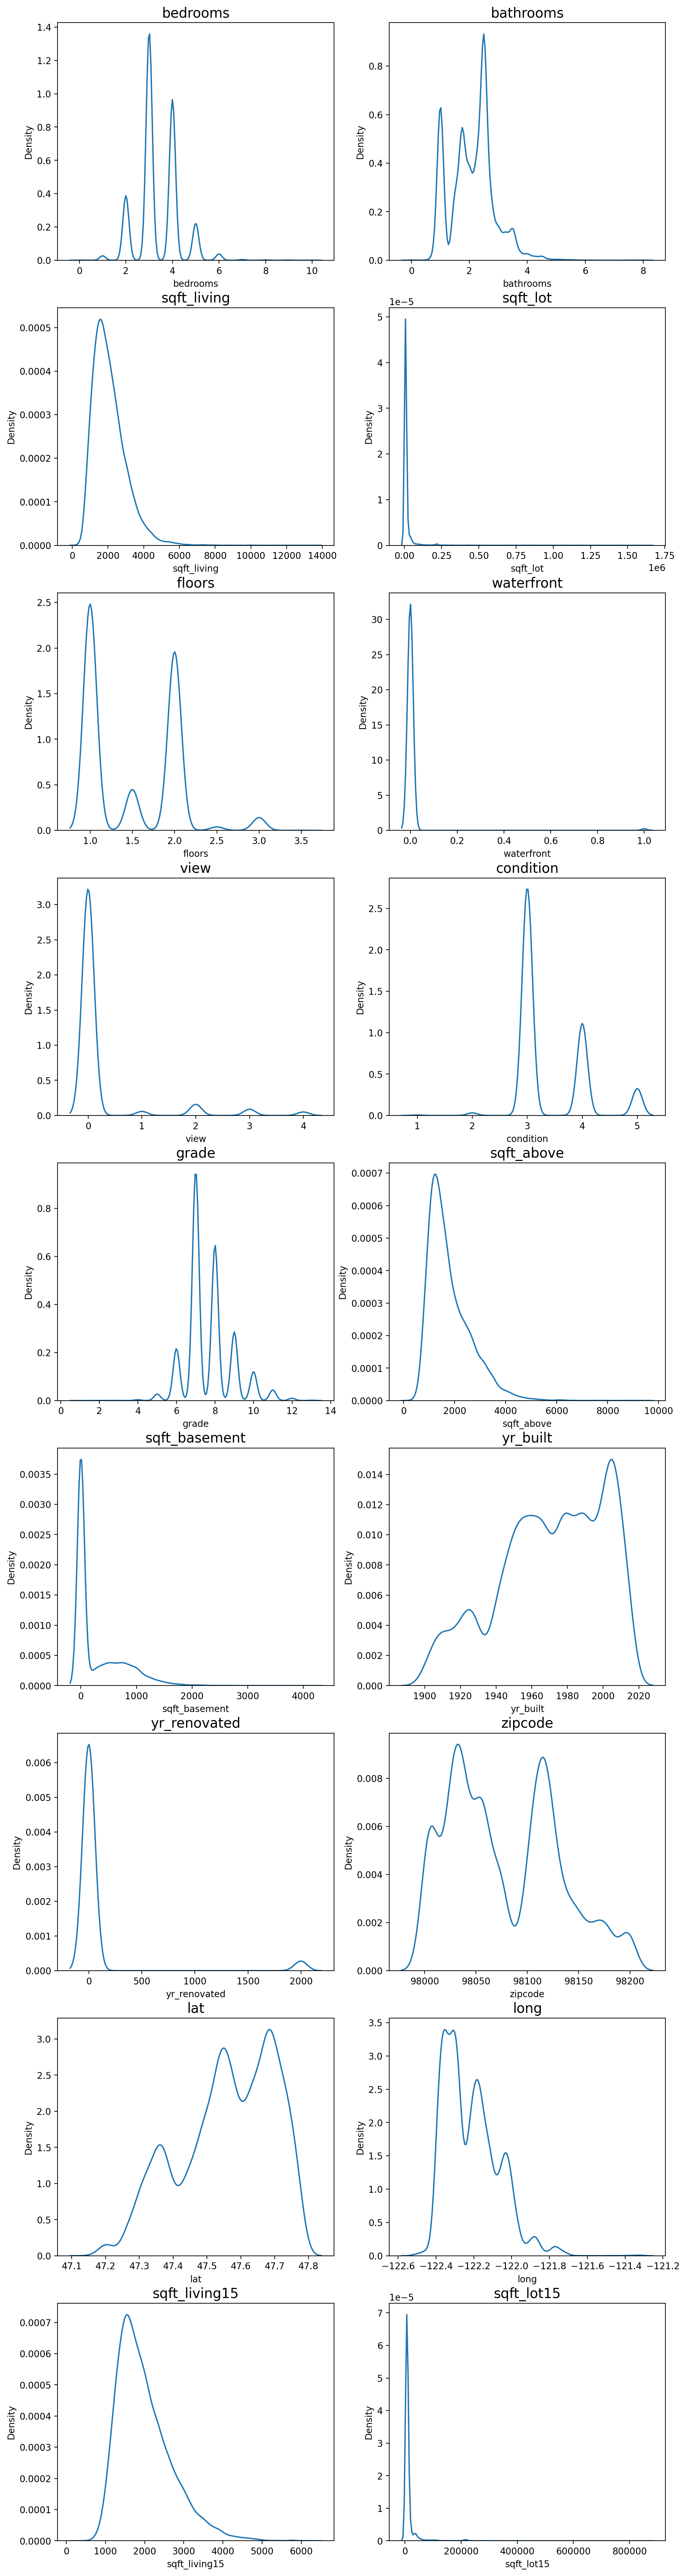

In [72]:
# 전처리 5 훈련 데이터 분포도 확인 및 처리
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [73]:
# 비 정규적인 칼럼 선택해 로그 변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

# 로그 변환
for c in skew_columns:
    train[c] = np.log1p(train[c].values)

In [74]:
# 테스트 데이터 또한 로그 변환
for c in skew_columns:
    test[c] = np.log1p(test[c].values)

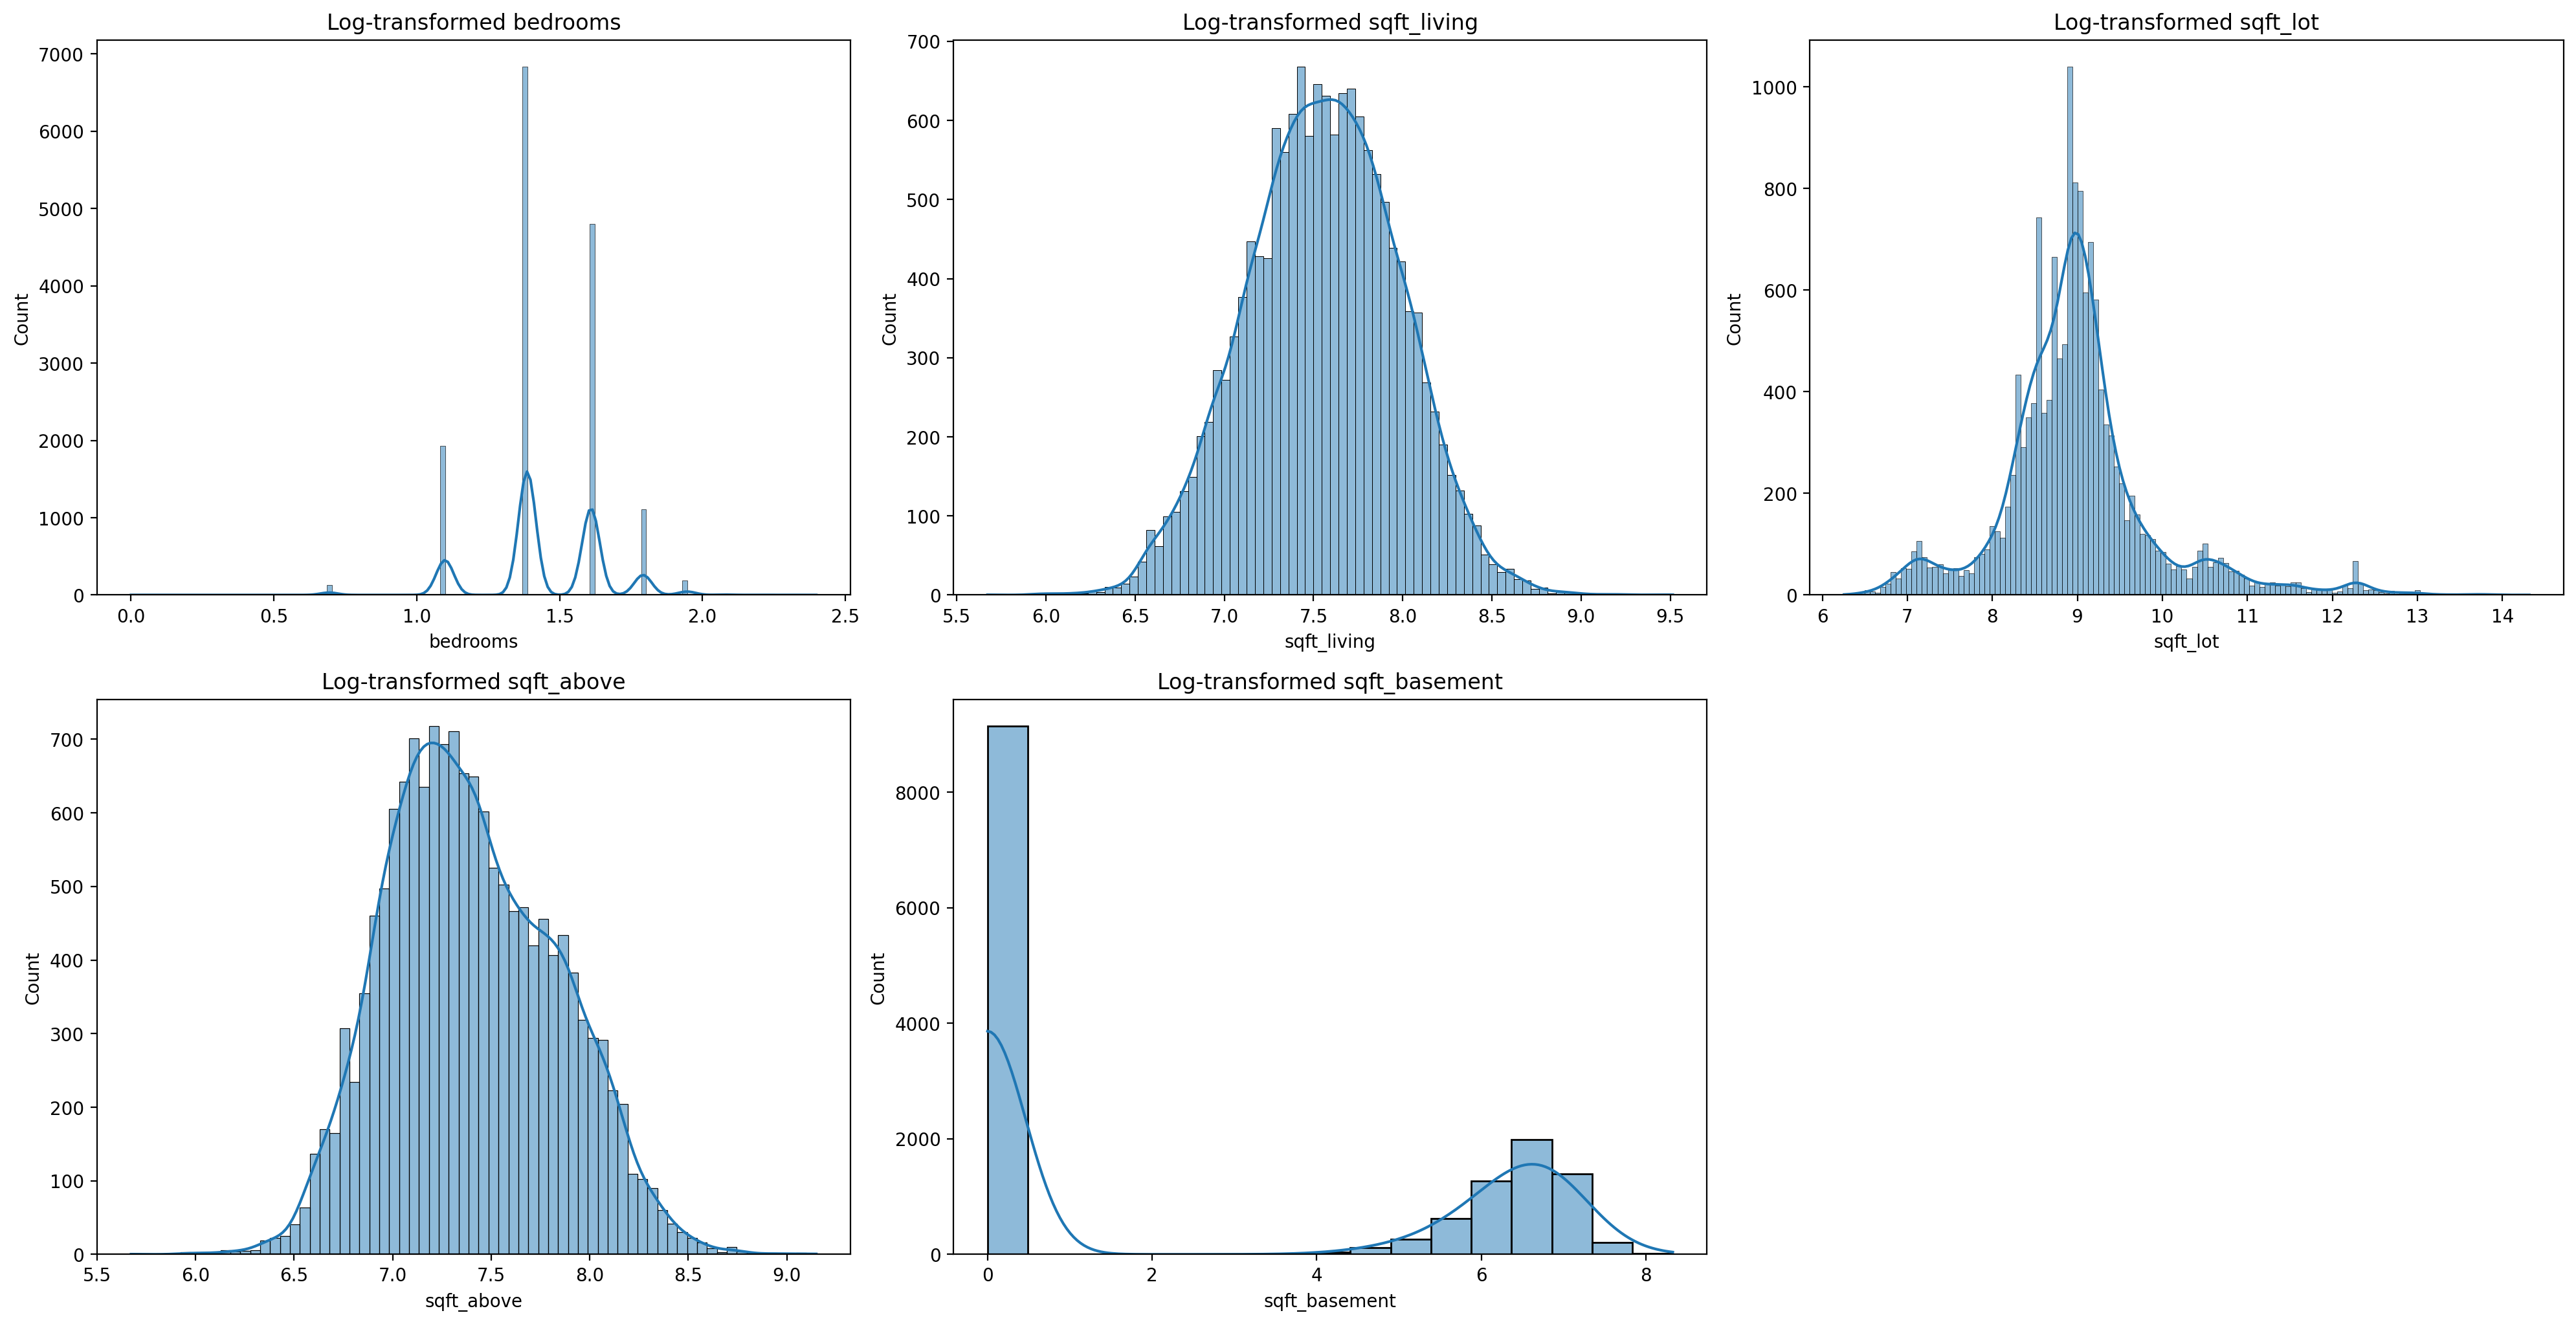

In [75]:
# 로그 변환된 컬럼들 시각화
plt.figure(figsize=(20, 15))

for i, column in enumerate(skew_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train[column], kde=True)
    plt.title(f'Log-transformed {column}')

plt.tight_layout()
plt.show()

# 모델 학습

In [76]:
# train_test_split과 mse계산읠 위해 함수 불러오기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 기존 y_test나 y_pred데이터에 로그 변환을 진행했기에 np.expm1()을 통해 원상복귀 작업을 잊지 말아야 한다
def rmse(y_test, y_pred):
  return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [94]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [99]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [30, 50]
}

In [100]:
random_state=42

In [101]:
# 그리드 탐색에 사용할 모델 불러오기
model = LGBMRegressor(random_state=random_state)

In [102]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [1, 10],
                         'n_estimators': [50, 100], 'num_leaves': [30, 50]},
             scoring='neg_mean_squared_error', verbose=1)

In [103]:
# 시각화 함수 구현
def view_result(model):
  # 결과 저장
  params = model.cv_results_['params']
  score = model.cv_results_['mean_test_score']

  # 데이터 프레임 생성
  results = pd.DataFrame(params)
  results['score'] = score

  # RMSLE 값 계산 후 컬럼명 변경
  results['RMSLE'] = np.sqrt(-1 * results['score'])

  # RMSLE 값이 낮은 순으로 정렬
  results = results.rename(columns={'RMSE': 'RMSLE'})
  results = results.sort_values(by='RMSLE', ascending=True)

  return results


In [104]:
view_result(grid_model)

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
15,0.10,10,100,50,-0.026911,0.164045
14,0.10,10,100,30,-0.027208,0.164948
13,0.10,10,50,50,-0.028334,0.168328
12,0.10,10,50,30,-0.029460,0.171638
10,0.10,1,100,30,-0.055023,0.234570
11,0.10,1,100,50,-0.055023,0.234570
8,0.10,1,50,30,-0.073398,0.270920
9,0.10,1,50,50,-0.073398,0.270920
7,0.01,10,100,50,-0.076779,0.277091
6,0.01,10,100,30,-0.081418,0.285338


In [105]:
# 위 결과를 통해 조건들 수정
model = LGBMRegressor(learning_rate=0.10, max_depth=10, n_estimators=100, num_leaves=50, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


array([13.05609171, 13.09418482, 14.16905132, ..., 13.02947718,
       12.68138221, 12.95897241])

In [111]:
# 다른 파라미터도 체크
param_grid = {
    'n_estimators': [50, 150],
    'num_leaves': [30, 700]
}

model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


GridSearchCV(cv=5, estimator=LGBMRegressor(max_depth=10, random_state=42),
             n_jobs=5,
             param_grid={'n_estimators': [50, 150], 'num_leaves': [30, 700]},
             scoring='neg_mean_squared_error', verbose=1)

In [112]:
view_result(grid_model)

,n_estimators,num_leaves,score,RMSLE
2,150,30,-0.026661,0.163281
3,150,700,-0.027749,0.166581
1,50,700,-0.028270,0.168136
0,50,30,-0.029460,0.171638


In [113]:
# 위에서 발견한 방식으로 모델 학습 진행
model = LGBMRegressor(max_depth=10, n_estimators=150, learning_rate=0.10, num_leaves=30, random_state=random_state)

In [114]:
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


array([13.12299336, 12.99062768, 14.15625819, ..., 13.02098884,
       12.71022392, 12.99667753])

# 예측

In [115]:
prediction = model.predict(test)
prediction

array([13.12299336, 12.99062768, 14.15625819, ..., 13.02098884,
       12.71022392, 12.99667753])

In [116]:
prediction = np.expm1(prediction)
prediction

array([ 500314.08899226,  438285.32247624, 1405997.36410866, ...,
        451796.2699889 ,  331114.95721828,  440944.92435421])

In [117]:
# sample submission 가져와 제출 형식 파일 확인
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

In [118]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.003141e+05
1,15036,4.382853e+05
2,15037,1.405997e+06
3,15038,3.104736e+05
4,15039,3.295779e+05


In [119]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', 'try4')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content/drive/MyDrive/대학/활동/아이펠/lms/기초다지기_rs8/나의 첫 번째 캐글 경진대회, 무작정 따라해보기/submission_lgbm_RMSLE_try4.csv
